Selected NEO: 2025 BF7 (close approach: 2025-Jan-18 16:59)


Wrote flyby NEO 2025 BF7 to neos.czml
SGP4 error 6 for ONEWEB-0690 at step 0
SGP4 error 6 for STARLINK-3053 at step 0
SGP4 error 6 for KAFASAT at step 0
Generated 97 valid sequences out of 100 TLEs.
SGP4 error 6 for ONEWEB-0690 at step 0
SGP4 error 6 for STARLINK-3053 at step 0
SGP4 error 6 for KAFASAT at step 0
Generated 97 valid sequences out of 100 TLEs.
Saved CesiumJSON → predictions_XGBoost.json
XGBoost Mean Error: 60742.86 km, Mean % Error: 104.15%


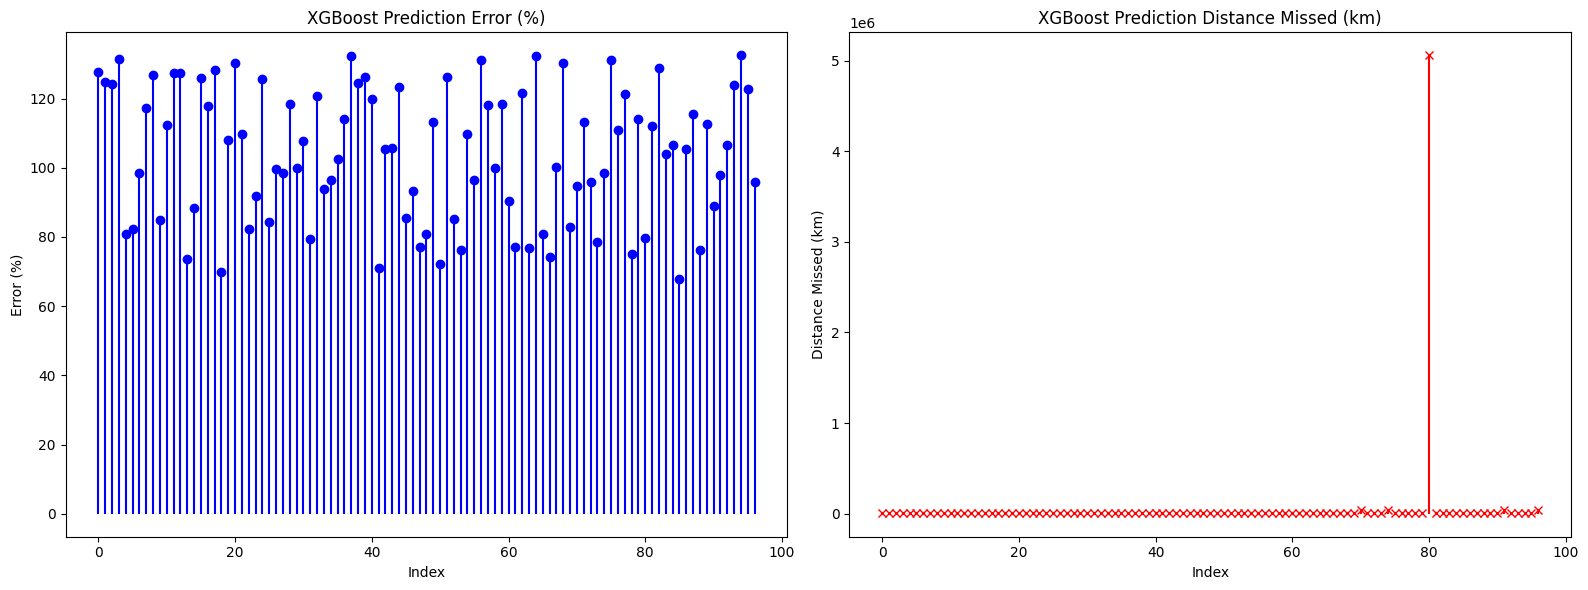

In [8]:

import shutil
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time

from training import (
    read_tles_from_file,
    generate_benchmark_positions,
    generate_sequences_from_tles,
    load_trained_model,
    load_xgboost_model,
    predict_sequence,
    predict_xgboost_sequence,
    save_predictions_for_cesium_with_actual,
    generate_neo_sequences, 
    auto_generate_flyby_neo_czml,
    write_flyby_neo_czml,
    evaluate_model_performance
)

# Generates a random NEO flyby CZML file for Cesium
auto_generate_flyby_neo_czml()

def launch_predictor():
    root = tk.Tk()
    root.title("Satellite Predictor")

    num_var   = tk.StringVar()               # empty to start
    model_var = tk.StringVar(value="LSTM")   # default choice

    # ─── Layout ────────────────────────────────────────────────────────────────
    tk.Label(root, text="Number of Satellites:")\
      .grid(row=0, column=0, sticky="e", padx=5, pady=5)
    entry_num = tk.Entry(root, textvariable=num_var, width=10)
    entry_num.grid(row=0, column=1, padx=5, pady=5)
    entry_num.focus_set()

    tk.Label(root, text="Select Model:")\
      .grid(row=1, column=0, sticky="e", padx=5, pady=5)
    ttk.Combobox(
      root, textvariable=model_var,
      values=["LSTM","GRU","XGBoost"],
      state="readonly", width=8
    ).grid(row=1, column=1, padx=5, pady=5)

    # ─── Action ────────────────────────────────────────────────────────────────
    def on_start(event=None):
        # 1) parse N
        try:
            n = int(num_var.get())
        except ValueError:
            return messagebox.showerror("Input Error","Enter a valid integer")

        # 2) pick TLE file
        file_path = filedialog.askopenfilename(
            title="Select TLE file",
            filetypes=[("Text files","*.txt"),("All files","*.*")]
        )
        if not file_path:
            return messagebox.showwarning("No File","You must choose a TLE .txt")

        # 3) build exactly N sequences + benchmarks  (full 7‐feature seqs)
        tles                = read_tles_from_file(file_path, num_samples=n)
        benchmark_positions = generate_benchmark_positions(
                                   tles=tles, num_points=30, step_sec=20
                               )
        sequences_all       = generate_sequences_from_tles(
                                   tles=tles, num_points=30, step_sec=20
                               )

        # keep full 7‐feature data around for RNNs
        sequences = sequences_all   # shape (N,30,7)

        # 4) predict
        model_name = model_var.get()
        if model_name=="XGBoost":
            # legacy 6‐feature XGB
            m, s = load_xgboost_model("xgb")
            scaler_n_features = s.n_features_in_
            sequences_xgb = sequences[:, :, :scaler_n_features]
            preds = predict_xgboost_sequence(m, s, sequences_xgb)
        else:
            # full‐7‐feature LSTM/GRU
            tag = model_name.lower()
            m, s = load_trained_model(tag)
            preds = predict_sequence(m, s, sequences)

        # 5) write JSON + proxy for Cesium
        save_predictions_for_cesium_with_actual(
            preds, benchmark_positions, model_name=model_name
        )
        shutil.copy(f"predictions_{model_name}.json","predictions.json")

        # 6) notify & close GUI
        messagebox.showinfo("Done",f"{model_name} predictions saved!")
        root.destroy()

        # 7) compute & plot errors side‐by‐side
        actual = sequences[:len(preds), -1, 0:3]  # (N,3)
        evaluate_model_performance(preds, actual, object_type=model_name)

    # ─── Bindings & Run ────────────────────────────────────────────────────────
    entry_num.bind("<Return>", on_start)
    root.bind("<Return>", on_start)
    root.bind("<Escape>", lambda e: root.destroy())
    tk.Button(root, text="Start Prediction", command=on_start)\
      .grid(row=2, column=0, columnspan=2, pady=10, ipadx=10)

    root.mainloop()

# ──────────────────────────────────────────────────────────────────────────────
# Launch the whole thing
# ──────────────────────────────────────────────────────────────────────────────
launch_predictor()